# Taxi Order Prediction

<b>Aim</b>

Build a model to predict the number of taxi orders for the next hour.

<br><b>Background</b>

The company "Sharp Taxi" has collected historical data on taxi orders at airports. The company wants to attract more drivers during peak times.

Important conditions:

- The RMSE value on the test sample should not exceed 48.
- Train different models with various hyperparameters. Make a test sample size of 10% of the original data.

<br><b>Data Description</b>

Target feature:

- *num_orders* — number of orders

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Check the chronology of the data
df.index.is_monotonic

True

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
df_good = df.copy(deep=True)

<b>Conclusions</b>

We have a dataset that spans from March 1, 2018, 00:00 to August 31, 2018, 23:50. The data is presented in chronological order. There are no missing values.

## Analysis

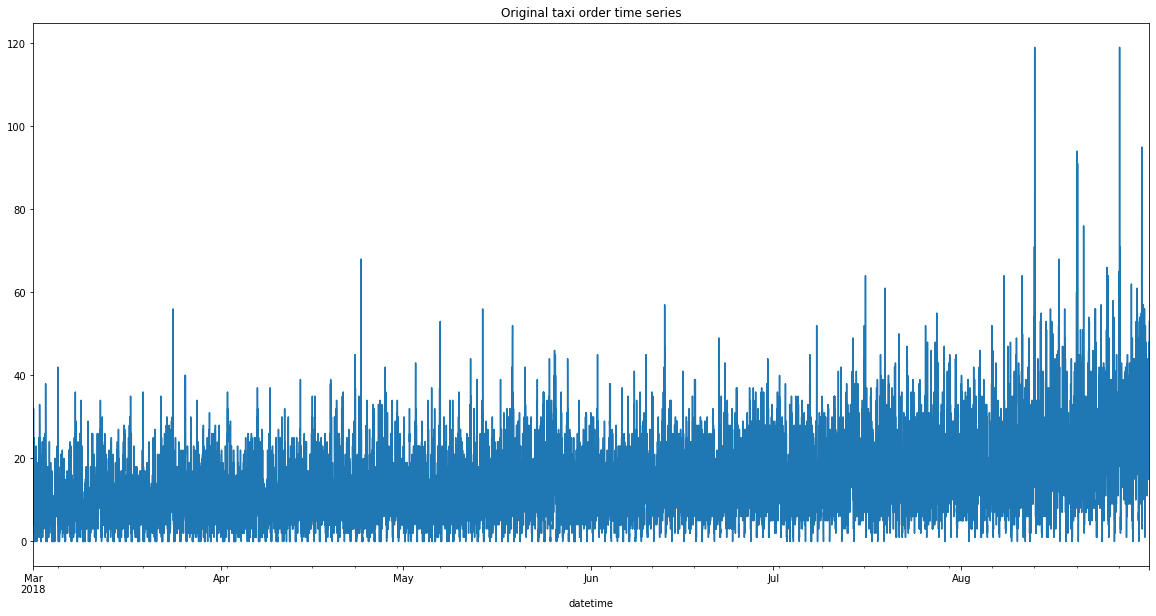

In [8]:
# Let's look at the overall chart

df_good['num_orders'].plot(figsize=(20,10))
plt.title('Original taxi order time series')
plt.show()

There seems to be an increasing trend, but of course, this chart is difficult to analyze.

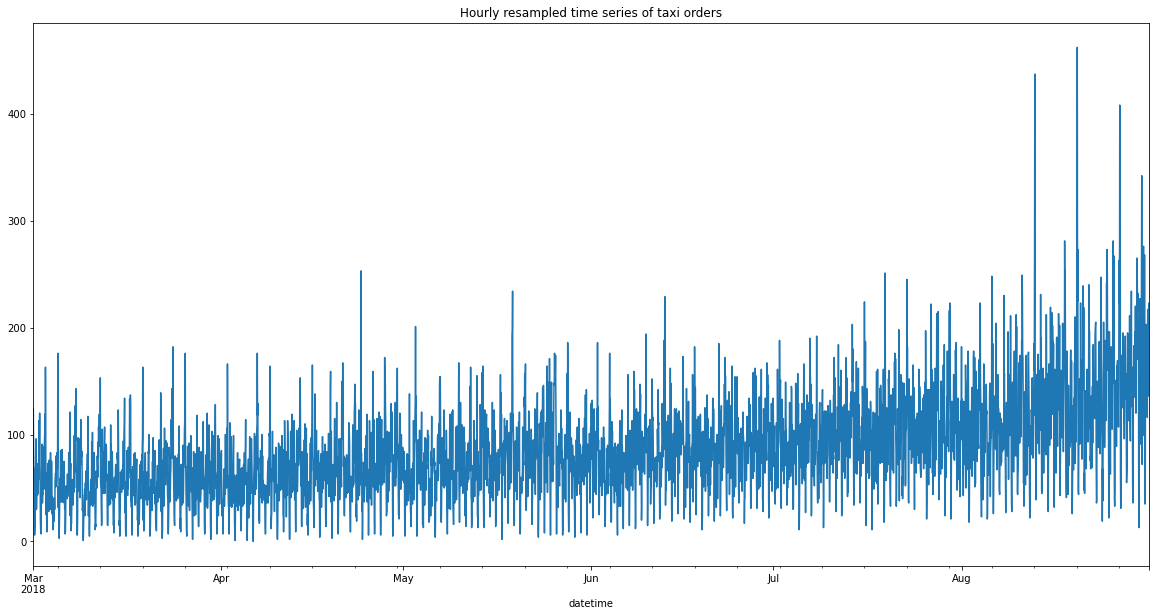

In [9]:
# Let's try different types of resampling and look at the charts

df_good_h = df_good.resample('1H').sum()
df_good_h['num_orders'].plot(figsize=(20,10))
plt.title('Hourly resampled time series of taxi orders')
plt.show()

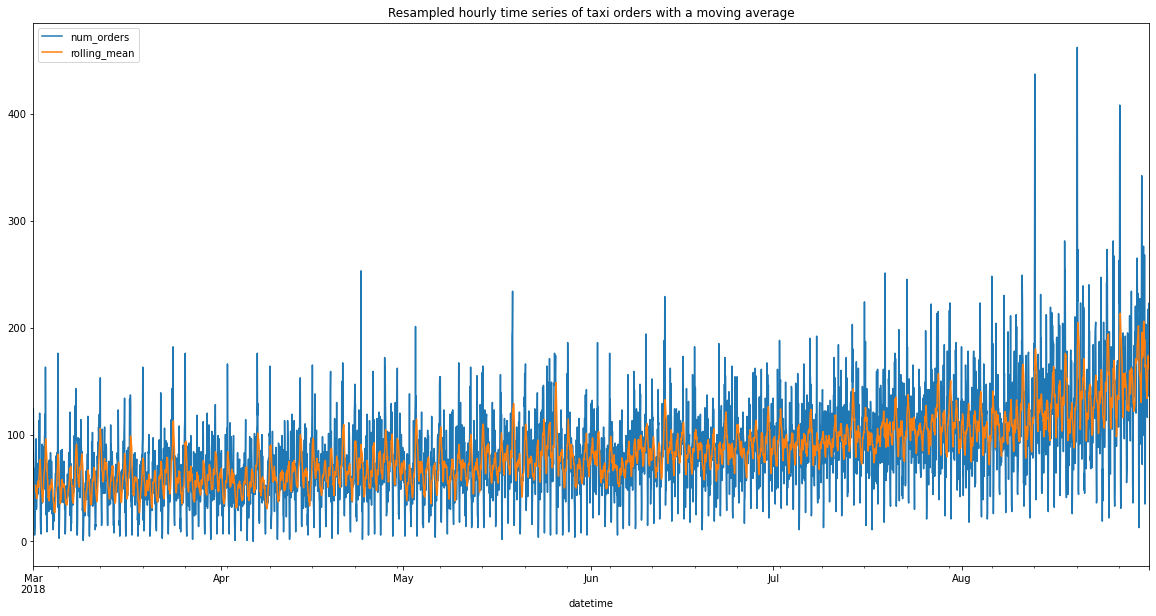

In [10]:
# This is still a somewhat unclear chart; let's use the addition of a moving average
df_good_h['rolling_mean'] = df_good_h.rolling(10).mean()
df_good_h.plot(figsize=(20,10))
plt.title('Resampled hourly time series of taxi orders with a moving average')
plt.show()

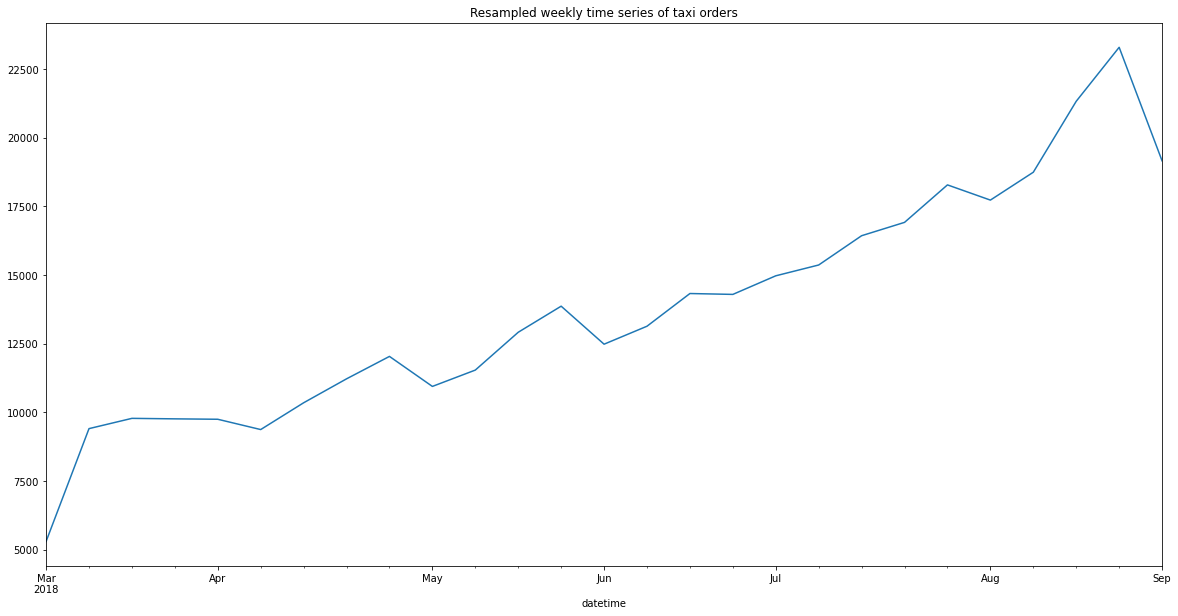

In [11]:
#Resampling by week
df_good_w = df_good.resample('1W').sum()
df_good_w['num_orders'].plot(figsize=(20,10))
plt.title('Resampled weekly time series of taxi orders')
plt.show()

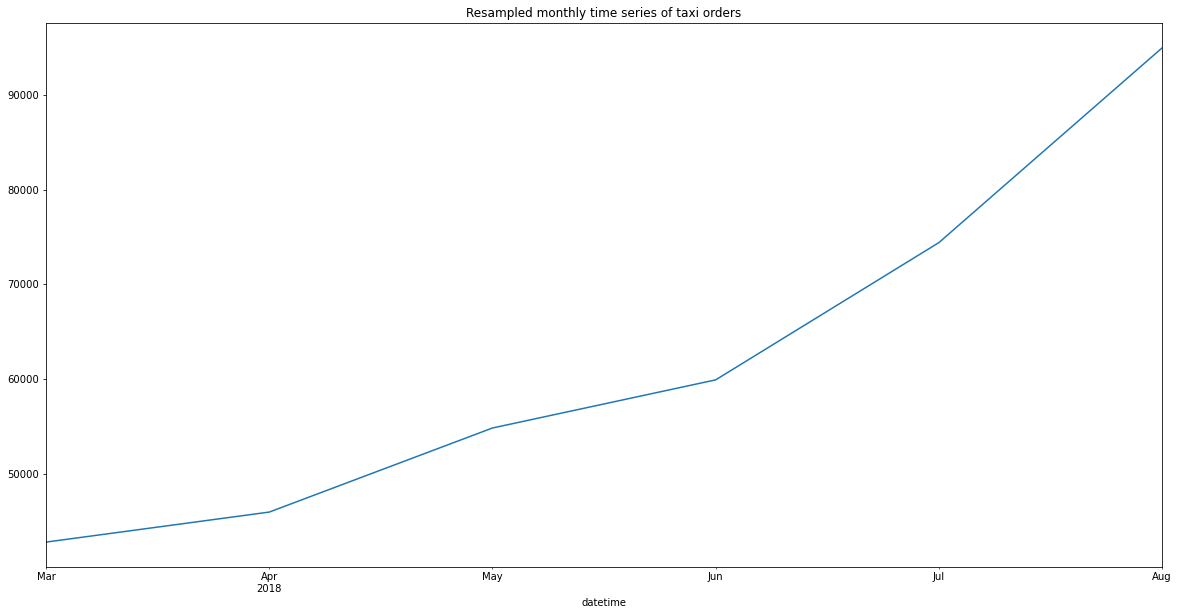

In [12]:
#Resampling by month
df_good_m= df_good.resample('1M').sum()
df_good_m['num_orders'].plot(figsize=(20,10))
plt.title('Resampled monthly time series of taxi orders')
plt.show()

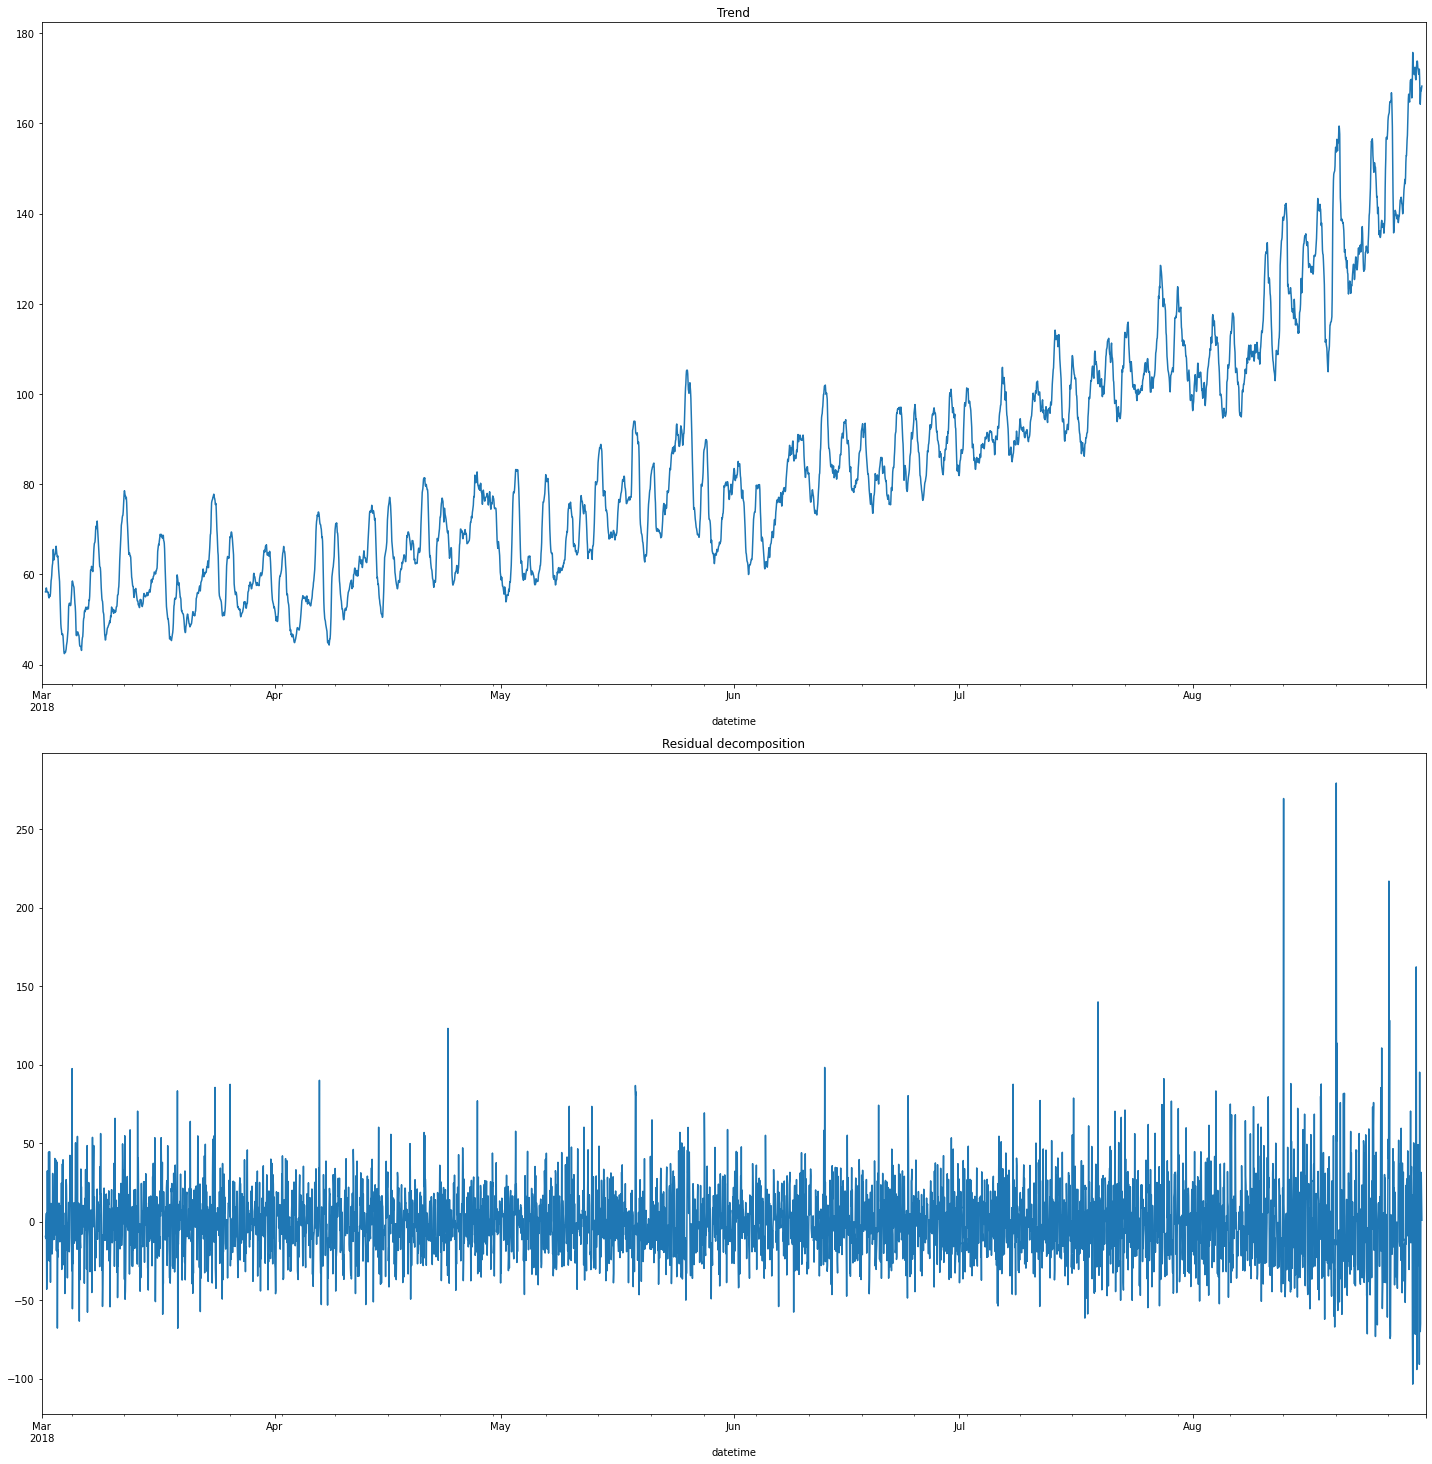

In [13]:
# evaluate the trend, seasonality, and residual decomposition charts

decomposed = seasonal_decompose(df_good_h['num_orders'])

plt.figure(figsize=(20, 30))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual decomposition')
plt.tight_layout()

Here we see an increasing trend and daily seasonality.

Let's look at the seasonality of the last week.

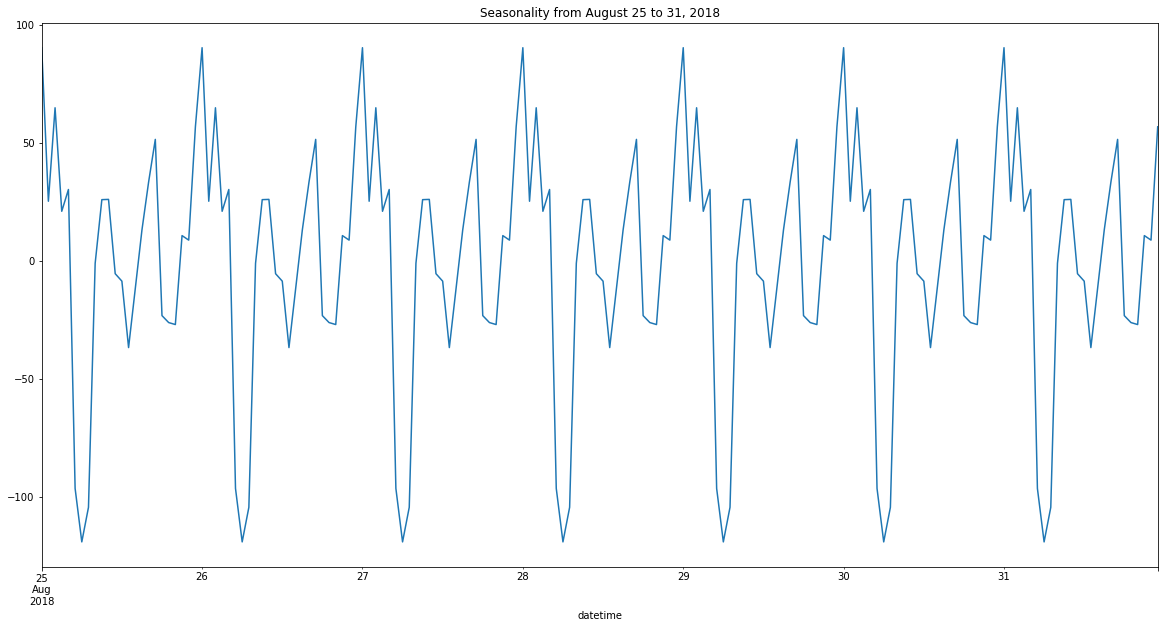

In [14]:
decomposed_last = seasonal_decompose(df_good_h['2018-08-25':'2018-08-31']['num_orders'])

decomposed_last.seasonal.plot(title='Seasonality from August 25 to 31, 2018', figsize=(20,10))
plt.show()

Here we see a decrease in demand at night, an increase in the morning and afternoon, and peak values in the evening.

<b>Conclusions</b>

We conducted an analysis of time series. We see that demand tends to increase. Furthermore, there are intra-day trends: a decrease in demand at night, growth in the morning and afternoon, and peak values in the evening. The data is ready for model training.

## Training

### Prepare to training

In [15]:
# Prepare the features

def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(window=rolling_mean_size).mean()

make_features(df_good_h, 24, 24)

In [16]:
# Create 2 datasets: training and test

df_train, df_test = train_test_split(df_good_h, shuffle=False, test_size=0.1)
df_train = df_train.dropna()
df_test = df_test.dropna()

In [17]:
# Separate features and the target variable
X_train = df_train.drop('num_orders', axis=1)
y_train = df_train['num_orders']
X_test = df_test.drop('num_orders', axis=1)
y_test = df_test['num_orders']

In [18]:
# Ensure that the datasets are split correctly
print(X_train.shape)
X_test.shape

(3950, 27)


(442, 27)

### Model Training

#### Linear Regression

In [19]:
# RMSE Function
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [20]:
start_time_lr_train = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time_lr_train
print(f"Linear Regression model training time : {training_time_lr:.3f} sec")

Linear Regression model training time : 0.486 sec


In [21]:
start_time_lr_pred = time.time()
#Make predictions on the test dataset
predictions_lr = model_lr.predict(X_test)
# Calculate the root mean square error (RMSE)
rmse_lr_test = rmse(y_test, predictions_lr)
prediction_time_lr = time.time() - start_time_lr_pred
print('RMSE of the Linear Regression model on the test dataset:', rmse_lr_test)
print(f"Prediction time of the Linear Regression model: {prediction_time_lr:.3f} sec")

RMSE of the Linear Regression model on the test dataset: 45.17810654807807
Prediction time of the Linear Regression model: 0.002 sec


#### Random Forest

In [22]:
# Tune hyperparameters for the Random Forest model

best_model_rf = None
best_result_rf = 100
best_depth_rf = 0
best_est_rf = 0
for est in tqdm(range(1,20,4)):
    for depth in range(1,20,4):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(X_train, y_train)
        predictions_rf = model_rf.predict(X_test)
        result_rf = mean_squared_error(y_test, predictions_rf)**0.5
        if result_rf < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_depth_rf = depth
            best_est_rf = est

print('The best RMSE on the test dataset for the Random Forest model is achieved with:', best_depth_rf, 
      'and n_estimators:', best_est_rf)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]

The best RMSE on the test dataset for the Random Forest model is achieved with: 13 and n_estimators: 17


In [23]:
start_time_rf_train = time.time()
#Train RF with the previously chosen hyperparameters
model_rf_test = RandomForestRegressor(random_state=12345, n_estimators=17, max_depth=13)
model_rf_test.fit(X_train, y_train)
training_time_rf = time.time() - start_time_rf_train
print(f"Training time of the Random Forest model: {training_time_rf:.3f} sec")

Training time of the Random Forest model: 0.617 sec


In [24]:
start_time_rf_pred = time.time()
#Test the model on the test dataset
prediction_rf_test = model_rf_test.predict(X_test)
rmse_rf_test = rmse(y_test, prediction_rf_test)
prediction_time_rf = time.time() - start_time_rf_pred
print('RMSE of the Random Forest model on the test dataset:', rmse_rf_test)
print(f"Prediction time of the Random Forest model: {prediction_time_rf:.3f} sec")

RMSE of the Random Forest model on the test dataset: 44.859132510216
Prediction time of the Random Forest model: 0.004 sec


#### CatBoost

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

In [26]:
# Create a CatBoostRegressor model
catboost_model = CatBoostRegressor(random_seed=12345, loss_function='RMSE', verbose=False)

# Range of hyperparameters for the CatBoostRegressor model
param_grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
    'iterations': [500, 1000],
}

# Create a GridSearchCV object
grid_search_cb = GridSearchCV(catboost_model, param_grid, cv=tscv, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Train the model while tuning optimal hyperparameters
grid_search_cb.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search_cb.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best hyperparameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03}


In [27]:
start_time_cb_train = time.time()
# Train the model with the best parameters on the training data
best_catboost_model = grid_search_cb.best_estimator_
best_catboost_model.fit(X_train, y_train)
training_time_cb = time.time() - start_time_cb_train
print(f"Training time of the CatBoost model: {training_time_cb:.3f} sec")

Training time of the CatBoost model: 3.455 sec


In [28]:
start_time_cb_pred = time.time()
# Evaluate the model's performance on the test dataset
predictions_catboost_test = best_catboost_model.predict(X_test)
rmse_catboost_test = rmse(y_test, predictions_catboost_test)
prediction_time_cb = time.time() - start_time_cb_pred
print("RMSE of the CatBoost model on the test dataset:", rmse_catboost_test)
print(f"Prediction time of the CatBoost model: {prediction_time_cb:.3f} sec")

RMSE of the CatBoost model on the test dataset: 40.86469384346526
Prediction time of the CatBoost model: 0.006 sec


#### LGBM

In [29]:
def rmse_scor(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))

# Create a scorer to evaluate the model's performance
rmse_scorer = make_scorer(rmse_scor, greater_is_better=False)

# Create an LGBMRegressor model
lgbm_model = LGBMRegressor(random_state=12345)

# Define a set of hyperparameters for iteration
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.3],
    'num_leaves': [31, 63],
    'min_child_samples': [10, 20]
}

# Create a GridSearchCV object
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=1,
    n_jobs=1,
    error_score='raise'
)

# Train the model using GridSearchCV
grid_search_lgbm.fit(X_train, y_train)

# Output the best parameters and quality score
print("Best parameters:", grid_search_lgbm.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 63}


In [30]:
start_time_lgbm_train = time.time()
# Train the model with the best parameters on the training data
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_model.fit(X_train, y_train)
training_time_lgbm = time.time() - start_time_lgbm_train
print(f"Training time of the LGBM model: {training_time_lgbm:.3f} sec")

Training time of the LGBM model: 0.398 sec


In [31]:
start_time_lgbm_pred = time.time()
# Evaluate the model's performance on the test dataset
predictions_lgbm_test = best_lgbm_model.predict(X_test)
rmse_lgbm_test = rmse(y_test, predictions_lgbm_test)
prediction_time_lgbm = time.time() - start_time_lgbm_pred
print("RMSE of the LGBM model on the test dataset:", rmse_lgbm_test)
print(f"Prediction time of the LGBM model: {prediction_time_lgbm:.3f} sec")

RMSE of the LGBM model on the test dataset: 41.82226374568607
Prediction time of the LGBM model: 0.006 sec


<b>Conclusions</b>

Models have been trained, and the best hyperparameters for the models have been determined. The Linear Regression model showed the best RMSE value.

## Testing

In [32]:
# construct a summary table

index = ['LinearRegression',
         'RandomForest',
         'CatBoost',
         'LGBM']
final_data = {'RMSE':[round(rmse_lr_test, 3),
                      rmse_rf_test,
                      rmse_catboost_test,
                      rmse_lgbm_test],
              'Training Time':[round(training_time_lr, 3),
                                training_time_rf,
                                training_time_cb,
                                training_time_lgbm],
               'Prediction Time':[round(prediction_time_lr, 3),
                                     prediction_time_rf,
                                     prediction_time_cb,
                                     prediction_time_lgbm]}
final_data_rating = pd.DataFrame(data=final_data, index=index)

# Considering there are 3 variables, let's assume they are of equal value, so we can weigh them:
final_data_rating['Final Score'] = (final_data_rating['RMSE'] * .34 \
                                       + final_data_rating['Training Time'] * .33 \
                                       + final_data_rating['Prediction Time'] * .33)
print('')
print('Summary Table:')
print('')
final_data_rating.sort_values(by = 'Final Score', ascending=True)


Summary Table:



,RMSE,Training Time,Prediction Time,Final Score
LGBM,41.822264,0.398034,0.005983,14.352895
CatBoost,40.864694,3.455188,0.005985,15.036183
RandomForest,44.859133,0.616906,0.003997,15.457003
LinearRegression,45.178000,0.486000,0.002000,15.521560


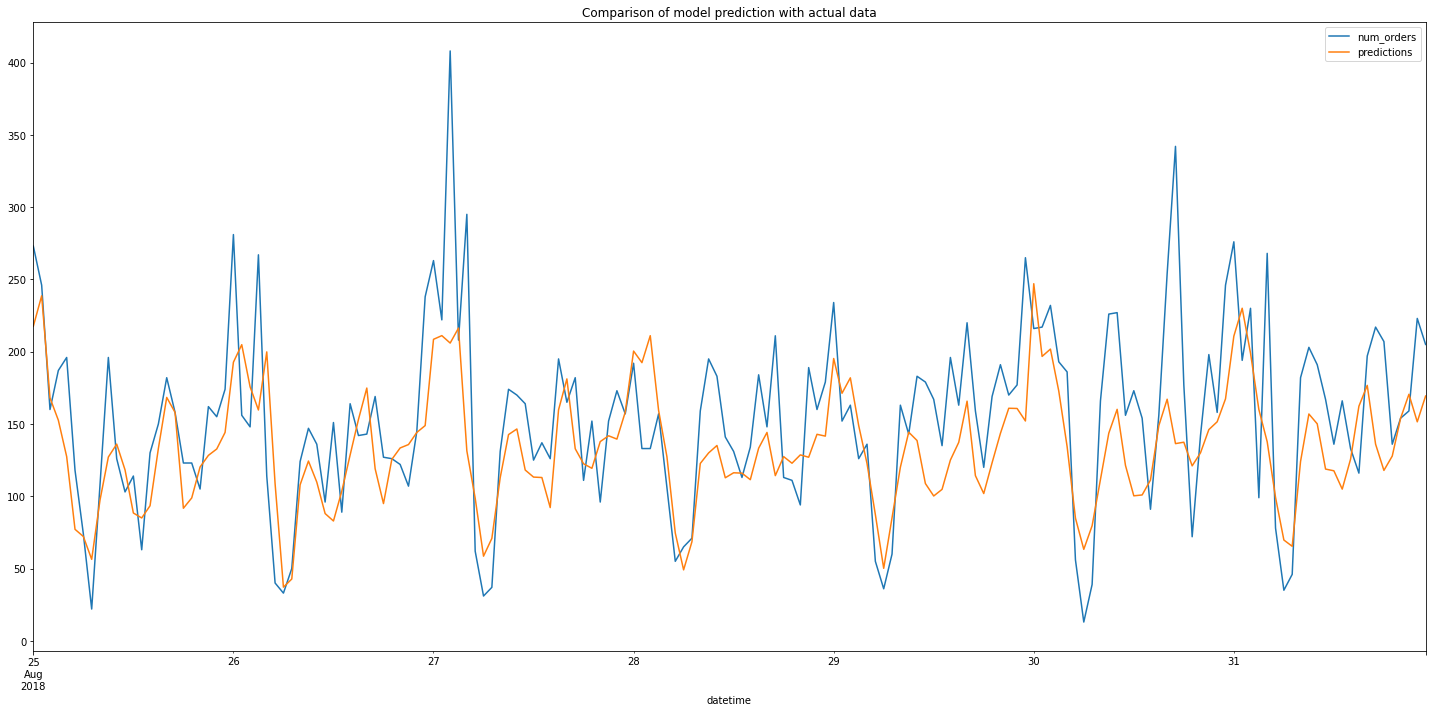

In [33]:
# Visualize the model's predictions and actual values
# since the best RMSE was shown by the CB model, let's use it
taxi_model_pred = pd.DataFrame(data = predictions_catboost_test, columns = ['predictions'], index = X_test.index)
df_graph = pd.merge(y_test, taxi_model_pred, how = 'left', left_index = True, right_index = True)
df_graph['2018-08-25':'2018-08-31'].plot(figsize=(20,10))
plt.title('Comparison of model prediction with actual data')
plt.tight_layout()

## Conclusion

We were tasked to build a model to predict the number of taxi orders for the next hour. The final RMSE value should not exceed 48.

We analyzed the dataset, prepared samples for training predictive models. For training, we chose 5 models: LinearRegression, RandomForest, CatBoost, LGBM. The quality metric is RMSE. While training the models, the most suitable hyperparameters were chosen.

We took into account 3 variables:

- prediction quality;
- prediction speed;
- training time.

According to the RMSE metric, the best model is CatBoost, and if the customer prioritizes this metric, we can recommend using this model. Taking into account the training and prediction time in the final analysis, the LGBM model shows slightly better results.

***